In [95]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, ToolMessage
from langchain.tools import tool
from langchain_core.prompts import ChatPromptTemplate


from dotenv import load_dotenv
import os
load_dotenv()

if os.environ['OPENAI_API_KEY']:
    print("OpenAI API Key is set.")
else:
    raise ValueError("OpenAI API Key is not set.")

OpenAI API Key is set.


In [96]:

llm = ChatOpenAI(model="gpt-5-nano")

# **TOOLS**

### **DuckDuckGo Search Tool**

In [97]:
from langchain_community.tools import DuckDuckGoSearchRun

@tool
def search_duckduckgo(query: str) -> str:

    """This tool searches the latest news on DuckDuckGo for the given query and returns the results."""
    duck_search = DuckDuckGoSearchRun()
    return duck_search.invoke(query)


### **Arxiv Query Tool**

In [98]:
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper

@tool
def arxiv_tool(query: str) -> str:

    """"This tool allows you to query the arXiv database for research papers."""
    arxiv_query = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())
    return arxiv_query.invoke(query)



### **Wikipedia Search Tool**

In [99]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

@tool
def wiki_tool(query: str):

    """This tool allows you to search Wikipedia for information on a given topic."""
    wiki_query = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
    return wiki_query.invoke(query)



### **Custom Tool**

In [100]:
@tool
def personal_info(name: str):

    """Use this tool to get personal information about Alice, Bob, or Charlie. 
    """

    info = {
        "Alice": "Alice is a software engineer with 5 years of experience in AI.",
        "Bob": "Bob is a data scientist who loves working with large datasets.",
        "Charlie": "Charlie is a product manager with a background in tech startups."
    }
    return info.get(name, "No information available for this person.")

### **TOOL BINDING**

In [101]:
tools = [search_duckduckgo, arxiv_tool, wiki_tool, personal_info]

llm_with_tools = llm.bind_tools(tools)

# **LangGraph Creation**

### **Create Schema**

In [102]:
from typing import TypedDict, List 

class graph_schema(TypedDict):
    messages: List

### **Create Node Functions**

In [103]:
def llm_node(state: graph_schema) -> graph_schema:
    
    messages = state['messages']

    # Prompt template for the LLM, including system instructions and the human input
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful assistant that can use tools to answer questions."),
            ("human", "{input}")
        ]
    )

    # LLM With Tools 
    # llm_with_tools 

    chain = prompt | llm_with_tools 

    response = chain.invoke({"input": messages})

    # Update the state with the new message
    state['messages'] = messages + [response]

    return state

In [104]:
# from langgraph.prebuilt import ToolNode
def tool_node(state: graph_schema) -> graph_schema:

    messages = state['messages']

    tools_by_name = {tool.name: tool for tool in tools}

    tool_results = []

    for tool_call in messages[-1].tool_calls:

        tool = tools_by_name[tool_call["name"]]

        observation = tool.invoke(tool_call["args"])

        tool_results.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))

    # Update the state with the tool results
    state['messages'] = messages + tool_results

    return state

### **Create Conditional Edge Function**

In [105]:
def if_tool_call(state: graph_schema) -> str:

    last_message = state['messages'][-1]

    if last_message.tool_calls:
        return "tool_node"
    else:
        return "end"

### **Create State Graph**

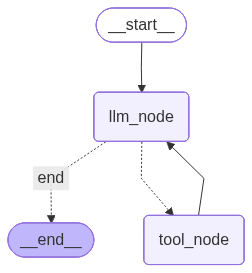

In [106]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(graph_schema)

# Add nodes to the graph
graph.add_node("llm_node", llm_node)
graph.add_node("tool_node", tool_node)

# Add edges between nodes
graph.add_edge(START, "llm_node")
graph.add_conditional_edges("llm_node", if_tool_call,{"tool_node": "tool_node", "end": END})
graph.add_edge("tool_node", "llm_node")
graph.add_edge("llm_node", END)


react_graph = graph.compile()

from IPython.display import Image, display

# You could see the errors with the below command
Image(react_graph.get_graph().draw_mermaid_png())


### **Graph Invocation**

In [107]:
react_graph.invoke({"messages": [HumanMessage(content="What is the latest news on AI?")]})

{'messages': [HumanMessage(content='What is the latest news on AI?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 348, 'prompt_tokens': 265, 'total_tokens': 613, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D8wOxrHyWLBbrjXwtVgWE1cKoplfe', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c5939-e1e5-73e3-8217-826646381485-0', tool_calls=[{'name': 'search_duckduckgo', 'args': {'query': 'latest AI news'}, 'id': 'call_BIPUDJwhnahKXHLsEbRNSX0z', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 265, 'output_tokens': 348, 'total_tokens': 6

In [109]:
for chunk in react_graph.stream(
    {"messages": [HumanMessage(content="What is the latest news on AI?")]},
    stream_mode="updates"
):
    print(chunk)
    

{'llm_node': {'messages': [HumanMessage(content='What is the latest news on AI?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 220, 'prompt_tokens': 265, 'total_tokens': 485, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D8wR6XTZAl4D0U7i7ObW5cVqIuJ7h', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c593b-e7eb-7fc2-87fb-7c93f450e9fb-0', tool_calls=[{'name': 'search_duckduckgo', 'args': {'query': 'latest AI news'}, 'id': 'call_DFfKQoaTaoR6rnPlTVDxxD3y', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 265, 'output_tokens': 220, 'total